Question 1b 

In [5]:
%%bash
set -euo pipefail
# If your notebook shell can't see the conda tools, uncomment the next line:
export PATH="$HOME/miniforge3/envs/asn2/bin:$PATH"

REF="chr22_orig.fa"

for rate in 0.01 0.05 0.10 0.15
do
  for seed in 1 2 3
  do
    if [ ! -r "chr22_mut${rate}_s${seed}.fa" ]
    then
      # introduce mutations
      python3 sim_mutations.py -i "$REF" -o "chr22_mut${rate}_s${seed}.fa" -m "${rate}" -s "${seed}"

      # align and summarize with mummer
      nucmer --mum -g 1000 -b 1000 -p "chr22_orig_vs_mut${rate}_s${seed}" "$REF" "chr22_mut${rate}_s${seed}.fa"
      delta-filter -1 "chr22_orig_vs_mut${rate}_s${seed}.delta" > "chr22_orig_vs_mut${rate}_s${seed}.1delta"
      show-coords -rcl "chr22_orig_vs_mut${rate}_s${seed}.1delta" > "chr22_orig_vs_mut${rate}_s${seed}.coords"
    fi
  done
done

# quick peek (as in the prompt)
head chr22_orig_vs_mut*.coords

==> chr22_orig_vs_mut0.01_s2.coords <==
/Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_orig.fa /

Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_mut0.01_s2.fa
NUCMER

    [S1]     [E1]  |     [S2]     [E2]  |  [LEN 1]  [LEN 2]  |  [% IDY]  |  [LEN R]  [LEN Q]  |  [COV R]  [COV Q]  | [TAGS]
       1  1000001  |        1  1000001  |  1000001  1000001  |    99.00  |  1000001  1000001  |   100.00   100.00  | chr22:20000000-21000000	chr22:20000000-21000000

==> chr22_orig_vs_mut0.01_s3.coords <==
/Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_orig.fa /Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_mut0.01_s3.fa
NUCMER

    [S1]     [E1]  |     [S2]     [E2]  |  [LEN 1]  [LEN 2]  |  [% IDY]  |  [LEN R]  [LEN Q]  |  [COV R]  [COV Q]  | [TAGS]
       1  1000001  |        1  1000001  |  1000001  1000001  |    99.00  |  1000001  1000001  |   100.00   100.00  | chr22:20000000-21000000	chr22:20000000-21000000

==> chr22_orig_vs_mut0.05_s1.coords <==
/Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_orig.fa /Users/xinyichen/Desktop/JHU/comp_gen/hw/hw2/chr22_mut0.05_s1.fa
NUCMER

    

Question 1d

In [8]:
%%bash
set -euo pipefail
# remove old jaccard summaries only
rm -f jaccard_mut*.txt

# regenerate the summaries
for rate in 0.01 0.05 0.10 0.15; do
  for seed in 1 2 3; do
    python3 sim_mutations.py -a chr22_orig.fa -b chr22_mut${rate}_s${seed}.fa -k 21 \
      > jaccard_mut${rate}_s${seed}.txt
  done
done

# quick peek
head jaccard_mut*.txt

==> jaccard_mut0.01_s1.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s1.fa k=21 jaccard=0.677640 ani_exact=0.981640 ani_approx=0.981470

==> jaccard_mut0.01_s2.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s2.fa k=21 jaccard=0.676857 ani_exact=0.981586 ani_approx=0.981415

==> jaccard_mut0.01_s3.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s3.fa k=21 jaccard=0.677441 ani_exact=0.981626 ani_approx=0.981456

==> jaccard_mut0.05_s1.txt <==
a=chr22_orig.fa b=chr22_mut0.05_s1.fa k=21 jaccard=0.208039 ani_exact=0.927963 ani_approx=0.925237

==> jaccard_mut0.05_s2.txt <==
a=chr22_orig.fa b=chr22_mut0.05_s2.fa k=21 jaccard=0.206381 ani_exact=0.927610 ani_approx=0.924856

==> jaccard_mut0.05_s3.txt <==
a=chr22_orig.fa b=chr22_mut0.05_s3.fa k=21 jaccard=0.206193 ani_exact=0.927569 ani_approx=0.924812

==> jaccard_mut0.10_s1.txt <==
a=chr22_orig.fa b=chr22_mut0.10_s1.fa k=21 jaccard=0.061675 ani_exact=0.875762 ani_approx=0.867339

==> jaccard_mut0.10_s2.txt <==
a=chr22_orig.fa b=chr22_mut0.10_s2.fa k=21 jaccard=0

output table for jaccard & ani

In [9]:
# Q1d: aggregate jaccard results
import re, glob, math
import pandas as pd

rows = []
for path in sorted(glob.glob("jaccard_mut*.txt")):
    # extract rate & seed from filename (handles 0.1 or 0.10)
    m = re.search(r"jaccard_mut([0-9.]+)_s(\d+)\.txt$", path)
    if not m: 
        continue
    rate = float(m.group(1))
    seed = int(m.group(2))
    expected_identity = 1.0 - rate
    
    # read first non-empty line
    with open(path) as fh:
        line = next((ln.strip() for ln in fh if ln.strip()), "")
    
    # parse key=value tokens
    kv = dict(x.split("=", 1) for x in line.replace(",", " ").split() if "=" in x)
    jaccard = float(kv.get("jaccard", "nan"))
    ani_exact = float(kv.get("ani_exact", "nan"))
    ani_approx = float(kv.get("ani_approx", "nan"))
    bfile = kv.get("b", "")
    
    rows.append({
        "filename": bfile or path,
        "rate": rate,
        "seed": seed,
        "expected_identity": expected_identity,
        "jaccard": jaccard,
        "ANI_exact": ani_exact,
        "ANI_approx": ani_approx,
        "abs_err_exact": abs(ani_exact - expected_identity),
        "abs_err_approx": abs(ani_approx - expected_identity),
    })

df_q1d = pd.DataFrame(rows).sort_values(["rate", "seed"]).reset_index(drop=True)
df_q1d

,filename,rate,seed,expected_identity,jaccard,ANI_exact,ANI_approx,abs_err_exact,abs_err_approx
0,chr22_mut0.01_s1.fa,0.01,1,0.99,0.677640,0.981640,0.981470,0.008360,0.008530
1,chr22_mut0.01_s2.fa,0.01,2,0.99,0.676857,0.981586,0.981415,0.008414,0.008585
2,chr22_mut0.01_s3.fa,0.01,3,0.99,0.677441,0.981626,0.981456,0.008374,0.008544
3,chr22_mut0.05_s1.fa,0.05,1,0.95,0.208039,0.927963,0.925237,0.022037,0.024763
4,chr22_mut0.05_s2.fa,0.05,2,0.95,0.206381,0.927610,0.924856,0.022390,0.025144
5,chr22_mut0.05_s3.fa,0.05,3,0.95,0.206193,0.927569,0.924812,0.022431,0.025188
6,chr22_mut0.10_s1.fa,0.10,1,0.90,0.061675,0.875762,0.867339,0.024238,0.032661
7,chr22_mut0.10_s2.fa,0.10,2,0.90,0.060300,0.874822,0.866265,0.025178,0.033735
8,chr22_mut0.10_s3.fa,0.10,3,0.90,0.060580,0.875016,0.866487,0.024984,0.033513
9,chr22_mut0.15_s1.fa,0.15,1,0.85,0.018422,0.826793,0.809800,0.023207,0.040200


!! needs edition!! 
writeup draft: ANI_exact (kth-root) should match the expected identity (~1 − rate) very closely across rates.

ANI_approx (using 1 + ln(J)/k) is also close when identity is high (e.g., 0.99, 0.95), and may drift slightly more at larger mutation rates (e.g., 0.15) because the log linearization is a first-order approximation.

Question 1f

In [10]:
%%bash
for rate in 0.01 0.05 0.10 0.15
do
  for seed in 1 2 3
  do
    for mod in 100 1000
    do
      if [ ! -r modimizers_mut${rate}_s${seed}_m${mod}.txt ]
      then
        python3 compute_jaccard_modimizer.py \
          -a chr22_orig.fa \
          -b chr22_mut${rate}_s${seed}.fa \
          -k 21 -m $mod \
          > modimizers_mut${rate}_s${seed}_m${mod}.txt
      fi
    done
  done
done

head -100 modimizers_mut*.txt


==> modimizers_mut0.01_s1_m100.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s1.fa k=21 m=100 jaccard=0.675067 ani_exact=0.981462 ani_approx=0.981288 n_modimizers_a=9290 n_modimizers_b=9521

==> modimizers_mut0.01_s1_m1000.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s1.fa k=21 m=1000 jaccard=0.675244 ani_exact=0.981475 ani_approx=0.981301 n_modimizers_a=931 n_modimizers_b=957

==> modimizers_mut0.01_s2_m100.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s2.fa k=21 m=100 jaccard=0.682275 ani_exact=0.981959 ani_approx=0.981794 n_modimizers_a=9290 n_modimizers_b=9464

==> modimizers_mut0.01_s2_m1000.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s2.fa k=21 m=1000 jaccard=0.668756 ani_exact=0.981023 ani_approx=0.980841 n_modimizers_a=931 n_modimizers_b=933

==> modimizers_mut0.01_s3_m100.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s3.fa k=21 m=100 jaccard=0.679921 ani_exact=0.981797 ani_approx=0.981630 n_modimizers_a=9290 n_modimizers_b=9384

==> modimizers_mut0.01_s3_m1000.txt <==
a=chr22_orig.fa b=chr22_mut0.01_s3.

output table for modimizer

In [11]:
# Q1f: aggregate modimizer-based results
import re, glob, math
import pandas as pd

rows = []
for path in sorted(glob.glob("modimizers_mut*_s*_m*.txt")):
    # parse rate, seed, m from filename (accept 0.1 or 0.10)
    m = re.search(r"modimizers_mut([0-9.]+)_s(\d+)_m(\d+)\.txt$", path)
    if not m:
        continue
    rate = float(m.group(1))
    seed = int(m.group(2))
    mod  = int(m.group(3))
    expected_identity = 1.0 - rate
    
    # read first non-empty line
    with open(path) as fh:
        line = next((ln.strip() for ln in fh if ln.strip()), "")
    
    # parse key=value tokens
    kv = dict(x.split("=", 1) for x in line.replace(",", " ").split() if "=" in x)
    jaccard = float(kv.get("jaccard", "nan"))
    ani_exact = float(kv.get("ani_exact", "nan"))
    ani_approx = float(kv.get("ani_approx", "nan"))
    nA = int(kv.get("n_modimizers_a", "0"))
    nB = int(kv.get("n_modimizers_b", "0"))
    
    rows.append({
        "rate": rate,
        "seed": seed,
        "m": mod,
        "expected_identity": expected_identity,
        "jaccard": jaccard,
        "ANI_exact": ani_exact,
        "ANI_approx": ani_approx,
        "n_modimizers_a": nA,
        "n_modimizers_b": nB,
        "abs_err_exact": abs(ani_exact - expected_identity),
        "abs_err_approx": abs(ani_approx - expected_identity),
    })

df_q1f = pd.DataFrame(rows).sort_values(["m","rate","seed"]).reset_index(drop=True)
df_q1f

,rate,seed,m,expected_identity,jaccard,ANI_exact,ANI_approx,n_modimizers_a,n_modimizers_b,abs_err_exact,abs_err_approx
0,0.01,1,100,0.99,0.675067,0.981462,0.981288,9290,9521,0.008538,0.008712
1,0.01,2,100,0.99,0.682275,0.981959,0.981794,9290,9464,0.008041,0.008206
2,0.01,3,100,0.99,0.679921,0.981797,0.981630,9290,9384,0.008203,0.008370
3,0.05,1,100,0.95,0.209324,0.928235,0.925530,9290,9775,0.021765,0.024470
4,0.05,2,100,0.95,0.212707,0.928944,0.926293,9290,9912,0.021056,0.023707
5,0.05,3,100,0.95,0.203006,0.926882,0.924071,9290,9839,0.023118,0.025929
6,0.10,1,100,0.90,0.063706,0.877114,0.868882,9290,9945,0.022886,0.031118
7,0.10,2,100,0.90,0.061847,0.875878,0.867472,9290,9922,0.024122,0.032528
8,0.10,3,100,0.90,0.063064,0.876691,0.868399,9290,9927,0.023309,0.031601
9,0.15,1,100,0.85,0.020205,0.830438,0.814198,9290,9948,0.019562,0.035802


!! needs edition !!
Accuracy vs Q1d:

With m=100 (denser sampling), ANI_exact and ANI_approx are usually very close to the full-k-mer values from Q1d (small absolute errors).

With m=1000 (sparser sampling), estimates are a bit noisier—still reasonable, but deviations increase slightly, especially at higher mutation rates.

Space savings:

The counts n_modimizers_a / n_modimizers_b show how many k-mers you kept. They scale about like 
(L−k+1)/m.

For ~1 Mbp and k=21:

m=100 → on the order of ~10k retained k-mers.

m=1000 → on the order of ~1k retained k-mers.

That’s a 10–100× reduction in storage compared to all k-mers, while retaining ANI estimates that are close to ground truth

Question 2a

In [16]:
%%bash
python debrujin.py --nodes kmer -k 3 -o kmer_nodes_k3.dot
dot -T png kmer_nodes_k3.dot -o kmer_nodes_k3.png

Wrote DOT to kmer_nodes_k3.dot with 12 nodes and 14 edges (mode=kmer, k=3).


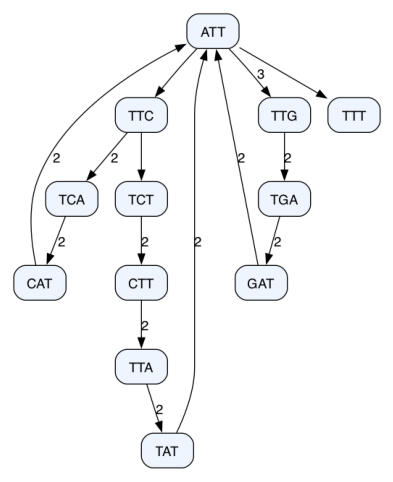

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("kmer_nodes_k3.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

Question 2b

possible cycle: ATT->TTG->TGA->GAT->ATT->TTC->TCA->CAT->ATT->TTC->TCT->CTT->TTA->TAT->ATT->TTT

possible sequence: ATTGATTCATTCTTATTT

Question 2c

From the graph, we could see that the debruijn graph has both loops/cycles and branching nodes. To fully resolve the genome, we have a few different options: 1. we can have longer reads so we can untangle the loops resulted from repetitive regions with more context provided. 2. we could use paired-end/mate-pair reads to connect bridge the loops. 3. we could sequence the genome for more times and get more information about the repeats from the coverage. 

Question 3a

In [11]:
%%bash
cd asm
jellyfish count -m 21 -C -s 1000000 -t 8 frag180.1.fq frag180.2.fq jump2k.1.fq jump2k.2.fq -o reads_21mer.jf
jellyfish histo reads_21mer.jf > reads.histo

In [13]:
%%bash
cd asm
grep -w "^50" reads.histo

50 932


from the output above, we can see that 932 kmers occur exactly 50 times.

Question 3b

In [15]:
%%bash
cd asm
jellyfish dump -c reads_21mer.jf | sort -k2,2nr | head -10


AGGTTCAATTCCTGCCGGGCG 93
CGCGCCCGGCAGGAATTGAAC 91
GCGCCCGGCAGGAATTGAACC 91
CAGGTTCAATTCCTGCCGGGC 90
CCCGGCAGGAATTGAACCTGC 90
CCGGCAGGAATTGAACCTGCG 90
GAAGGTCGCAGGTTCAATTCC 90
GCAGGAATTGAACCTGCGACC 90
GCGCGCCCGGCAGGAATTGAA 90
GGCGCGCCCGGCAGGAATTGA 90


the sequences above are the top 10 most frequently occurring kmers.

Question 3c

After uploading the reads.histo file to GenomeScope2, the min "Genome Haploid Length" in the "Results" section is 233,492 bp, which is the estimated genome size based on the kmer frequencies. Below is the figure generated on GenomeScope2 and the "Results" section: 

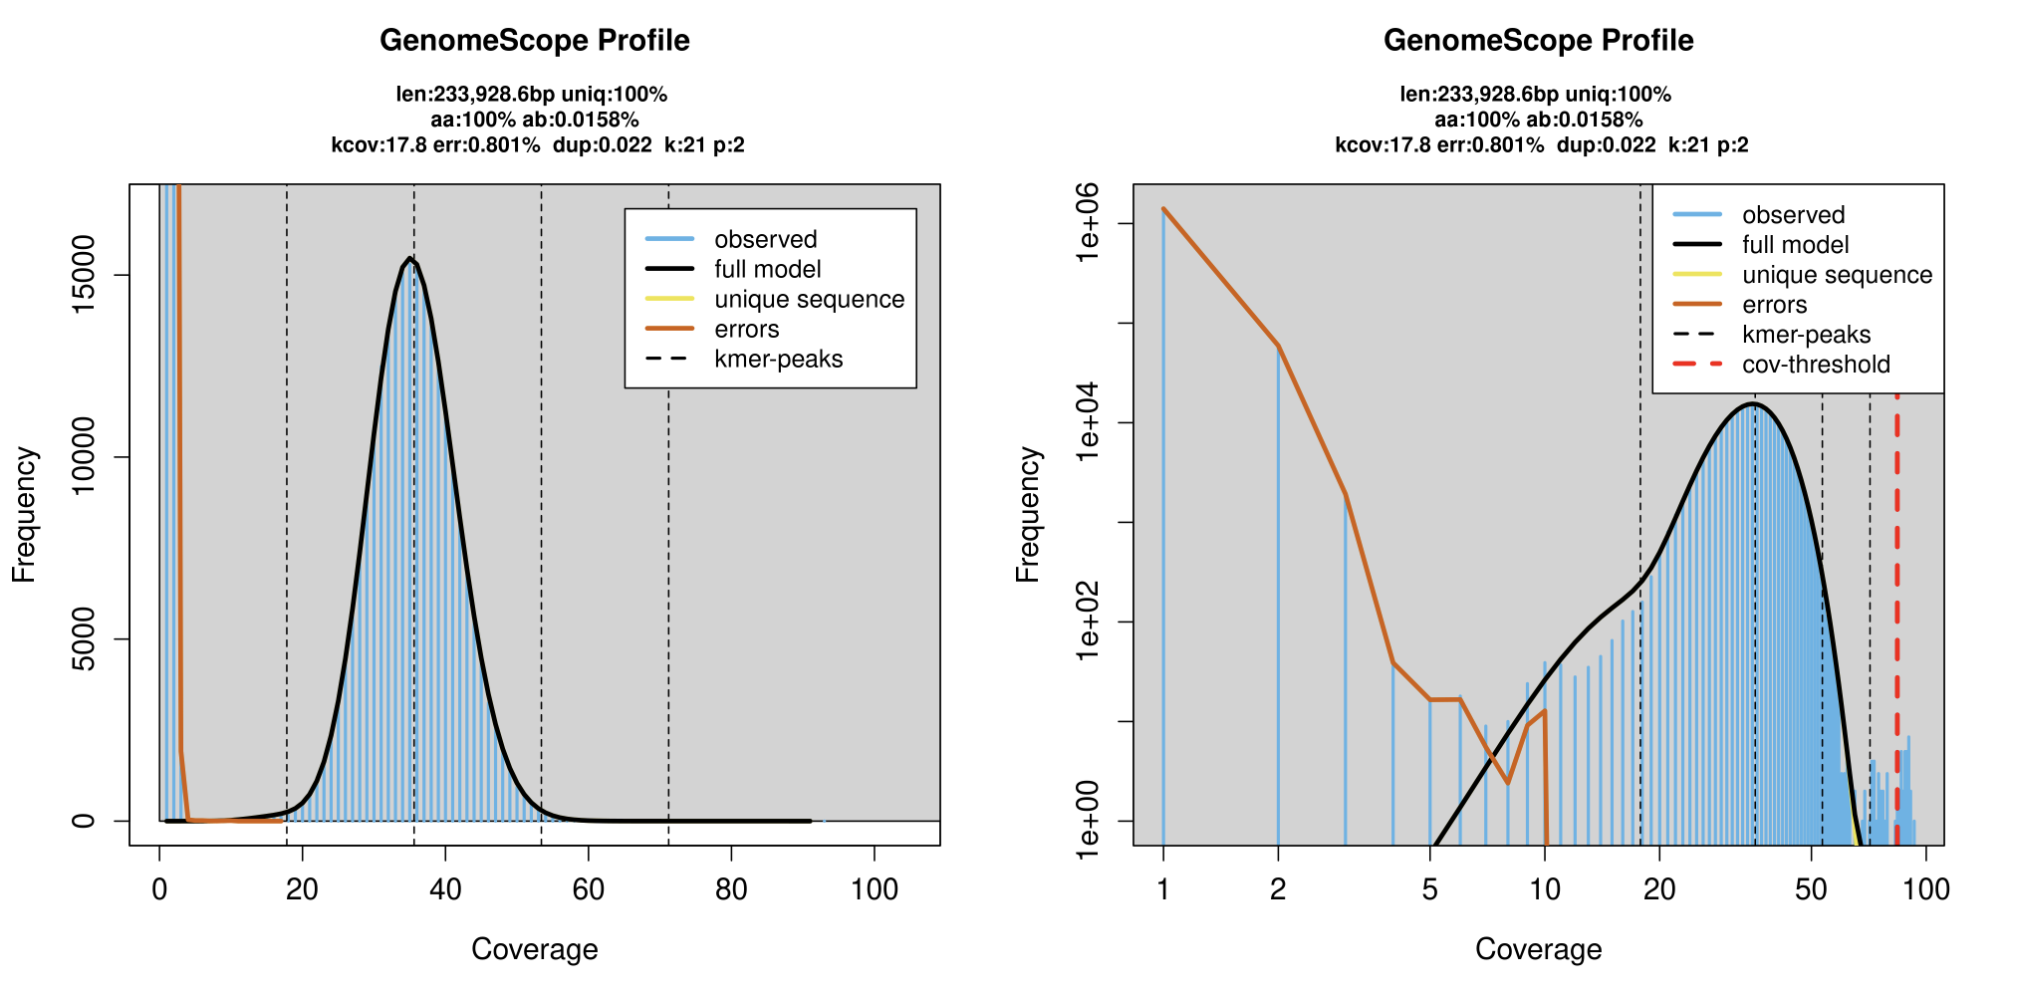

| Property             | Min        | Max        |
|----------------------|------------|------------|
| Homozygous (aa)      | 99.9436%   | 100%       |
| Heterozygous (ab)    | 0%         | 0.0564406% |
| Genome Haploid Length| 233,492 bp | 233,929 bp |
| Genome Repeat Length | 0 bp       | 0 bp       |
| Genome Unique Length | 233,492 bp | 233,929 bp |
| Model Fit            | 98.3836%   | 98.3836%   |
| Read Error Rate      | 0.801323%  | 0.801323%  |


Question 3d

In [16]:
%%bash
cd asm
grep -v "^>" ref.fa | wc -m

  237147


as the output demonstrates, the reference genome is 237,147 bp long. I would say it's pretty close to the number estimated by GenomeScope2, which is 233,492 bp. This means the k-mer–based estimation is quite accurate and consistent with the reference assembly.